## Classification problem

What if the output variable we want to predict is not continuous but binary? Yes or no?

Or can take the value of from a finite set of predefined categories? This more general case can be transformed into a series of binary classification problems. More on that later.

Classes can be ordinal or categorical:

- Ordinal values: Categories have an order, like grade A, B, C; 5-star scale; size classes. Close to a regression problem but if the number of classes is small, treating it as classification is usually better.

- Categorical values: Categories have no natural order, for example, colors, blood type.

### Try using linear regression

We can try to use linear regression as learnt earlier. Who cares if the $y$ values are all 0 or 1!?

![Source: https://www.enjoyalgorithms.com/blog/logistic-regression-in-ml](lin_reg_class.png)

Instead of the predicted continuous value, we output $1$ if $y\geq0.5$, and $0$ if $y<0.5$.

#### A linear fit is not always good for classification

![Source: https://medium.com/@imamun/linear-vs-logistic-regression-defe7ce7dcf2](bad_fit.jpg)

The parts where $y<0$ or $1<y$ have false errors.

Outliers can skew the linear function to a bad position.

### Logistic regression

Instead of a linear function, we need a function that more closely fits these 0-1 values.

We could use the Heaviside step function, which is 0 for $x<0$ and 1 for $x\geq 0$ but it is not differentiable, so we couldn't use gradient descent for fitting.

Here comes the logistic (or sigmoid) function.

![](https://vitalflux.com/wp-content/uploads/2022/03/logistic-regression-model-1.png)

Play with the parameters [on Desmos](https://www.desmos.com/calculator/mju5rfiyju)

#### A different error function is needed as well

The advantage of the sigmoid function is that it fits better than a line. But there is a problem.

If we use the MSE (Mean Square Error) function to measure its error, we get a wrinkly, non-convex surface with lots of local minima. Gradient descent would easily get stuck in a local optimum.

![Source: https://www.baeldung.com/cs/gradient-descent-logistic-regression](https://www.baeldung.com/wp-content/uploads/sites/4/2021/01/log-reg-sse_cost.png)

So the Maximum Likelihood Estimation (MLE) is used instead. The mathematical explanation behind it is beyond our scope, it is based on statistics and probability theory, and the function to minimize looks like this, where $p$ is the predicted value by the sigmoid function:

$$-\sum_{i=1}^m \left(y_i \cdot log(p) + (1-y_i) \cdot log(1-p) \right)$$

As $y_i$ is either 0 or 1, the error for element $i$ is either $-log(1-p)$ or $-log(p)$. So the error is very small if the predicted value is close to the actual value, and very large if they are far apart.

![](https://cdn-images-1.medium.com/max/1600/1*DMK-83I5WscTDtGpEBxkTw.png)

This error function is convex, so it is much easier to optimize. It can be done with gradient descent, similarly as in linear regression. Here, we only look at the methods already implemented in the scikit-learn library.

#### Example: Will a person buy an SUV?

Data source: [Kaggle](https://www.kaggle.com/datasets/iamaniket/suv-data)

In [14]:
import pandas as pd

df = pd.read_csv("suv_data.csv")
df


,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


##### Feature selection

Should we use Gender as an input variable? Does it help in predicting if a person will buy an SUV or not?

How can we determine?

In [15]:
import plotly.express as px

fig = px.histogram(df, x="Purchased", color="Gender", barmode="group")
fig.show()


In [16]:
# remove User ID and Gender columns
df.drop(["User ID", "Gender"], axis=1, inplace=True)
# independent variables
X = df.drop("Purchased", axis=1)
y = df["Purchased"]


#### Train the model

In [17]:
# create training and test datasets
from sklearn.model_selection import train_test_split

# random selection of training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

# scale data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
# fit mean and std to training data
X_train = sc.fit_transform(X_train)
# for test data, no fitting, just transform
# using the mean and std from the training set
# this avoids introducing bias to the model
# tests should be independent from each other
X_test = sc.transform(X_test)

# train the model
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()  # default settings
classifier.fit(X_train, y_train)


LogisticRegression()

In [19]:
classifier.coef_, classifier.intercept_


(array([[2.07665837, 1.11008221]]), array([-0.95217247]))

In [25]:
# test prediction
y_pred = classifier.predict(X_test)
# if we are more concerned about false negatives, we can change the output of uncertain predictions
for i, score in enumerate(classifier.decision_function(X_test)):
    y_pred[i] = int(score > -0.2)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1], dtype=int64)

In [26]:
correct, wrong = 0, 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        correct += 1
    else:
        wrong += 1
print(f"{correct=}, {wrong=}")
print(y_test.value_counts())


correct=90, wrong=10
Purchased
0    68
1    32
Name: count, dtype: int64


In [27]:
# evaluate predictions
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
fig = px.imshow(
    img=cm,
    labels={"x": "Prediction", "y": "Actual"},
)
fig.show()

Accuracy:  0.9
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        68
           1       0.87      0.81      0.84        32

    accuracy                           0.90       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.90      0.90      0.90       100

[[64  4]
 [ 6 26]]


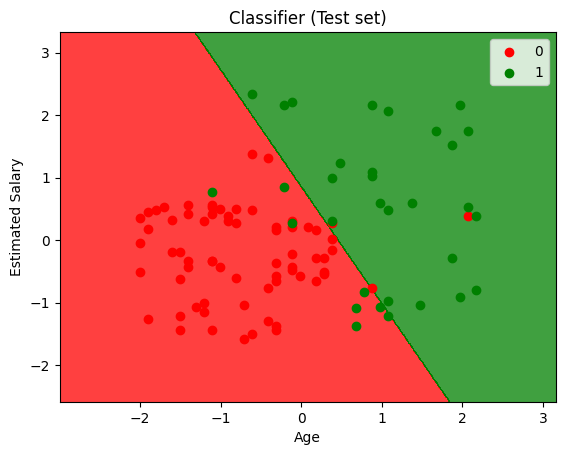

In [28]:
# Visualize model and prediction
# Source: https://www.geeksforgeeks.org/ml-logistic-regression-using-python/
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

X_set, y_set = X_test, y_test
# Create a mesh grid on which we will run our model
X1, X2 = np.meshgrid(
    np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
    np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01),
)

plt.contourf(
    X1,
    X2,
    classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
    alpha=0.75,
    cmap=ListedColormap(["red", "green"]),
)

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(
        X_set[y_set == j, 0],
        X_set[y_set == j, 1],
        color=ListedColormap(["red", "green"])(i),
        label=j,
    )

plt.title("Classifier (Test set)")
plt.xlabel("Age")
plt.ylabel("Estimated Salary")
plt.legend()
plt.show()

### Support Vector Machines (SVMs)

A different method for classification (or regression).

Based on geometric intuition rather than statistical analysis.

Idea: Find a boundary between the classes that is the *furthest* from both (or more) categories. (Maximizes the margin.)

Distance is measured to the closest point of a category. Data points well inside the region of the category do not affect the boundary position. (And as they are not used in the computation, the method is also more efficient.)

There may not be a clear boundary between the classes (as in the example above), then a tolerance is introduced that allows points being on the wrong side.

More on SVMs: [Hungarian article](https://sajozsattila.home.blog/2019/07/02/support-vector-machine/) on the math behind SVMs

![Source: https://medium.com/axum-labs/logistic-regression-vs-support-vector-machines-svm-c335610a3d16](https://miro.medium.com/max/722/1*sWXmiaVplPdP1Zrv-0xifA.png)

SVMs are usually better than logistic regression for unstructured data, like images, texts. It's hard to predict which method is better for a certain problem, so it's best to try both.

In [36]:
from sklearn import svm

clf = svm.SVC(kernel="rbf")
clf.fit(X_train, y_train)

# evaluation (copied from above)

# test prediction
y_pred = clf.predict(X_test)
# evaluate predictions
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
fig = px.imshow(
    img=cm,
    labels={"x": "Actual", "y": "Prediction"},
)
fig.show()

Accuracy:  0.93
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        68
           1       0.88      0.91      0.89        32

    accuracy                           0.93       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.93      0.93      0.93       100

[[64  4]
 [ 3 29]]


In [33]:
clf.coef_

AttributeError: coef_ is only available when using a linear kernel

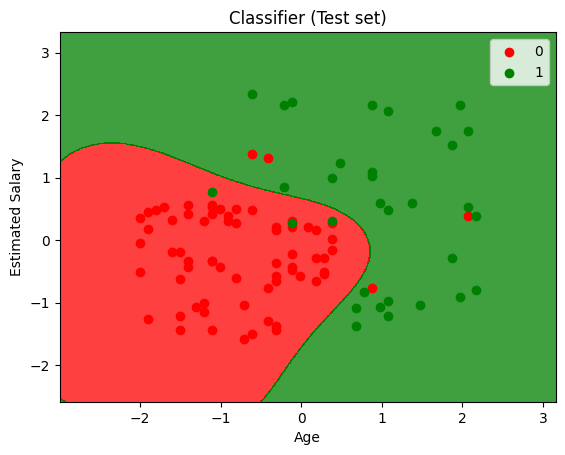

In [37]:
# Visualize model and prediction
# Source: https://www.geeksforgeeks.org/ml-logistic-regression-using-python/
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

X_set, y_set = X_test, y_test
# Create a mesh grid on which we will run our model
X1, X2 = np.meshgrid(
    np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
    np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01),
)

plt.contourf(
    X1,
    X2,
    clf.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
    alpha=0.75,
    cmap=ListedColormap(["red", "green"]),
)

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(
        X_set[y_set == j, 0],
        X_set[y_set == j, 1],
        color=ListedColormap(["red", "green"])(i),
        label=j,
    )

plt.title("Classifier (Test set)")
plt.xlabel("Age")
plt.ylabel("Estimated Salary")
plt.legend()
plt.show()


To get a more precise separation between classes, the boundary should be a curve instead of a line. (A curved hyperplane instead of linear hyperplane.)

This is achieved more easily by transforming the input data with a nonlinear function (called kernel function) then fitting a linear boundary on the transformed values.

![Source: https://medium.com/@apurvjain37/support-vector-machine-s-v-m-classifiers-and-kernels-9e13176c9396](https://miro.medium.com/v2/resize:fit:720/format:webp/1*gXvhD4IomaC9Jb37tzDUVg.png)

Actually, we don't even need the transformed values, only their distances.
This is exploited by the so-called Kernel Trick for more efficient computation.
The method is well illustrated in this [video by Visually Explained](https://www.youtube.com/embed/Q7vT0--5VII).

### Multiclass (multinomial) classification

There may be more than 2 classes to sort the elements into.

Some classification methods can deal with this too, some are capable of only binary classification. But multiclass problems can be solved through a series of binary problems as well.

<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2020/10/multiclass-svm1.png" alt="Source: https://www.baeldung.com/cs/svm-multiclass-classification" style="background-color:white"/>

#### Transformation to binary

##### One-vs-one

Train a classifier for each class-pair.

Prediction is done by using the classifiers' results as votes, and the predicted class is the one with the most votes.

With `sklearn.svm.SVC` set `decision_function_shape = "ovo"`.

<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2020/10/multiclass-svm2-e1601952762246.png" alt="Source: https://www.baeldung.com/cs/svm-multiclass-classification" style="background-color:white"/>

##### One-vs-rest

Train a classifier for each class $c$, where the original class value $y_c$ is converted to a binary dependent variable: $y = (y_c \equiv c)$.

Prediction is done by selecting the class of the classifier with the highest prediction probability of $y_c=1$.

With `sklearn.svm.SVC` set `decision_function_shape = "ovr"` (this is the default).
[Note](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html): internally, it still uses "ovo" method for fitting the binary SVM models and the "ovr" matrix is calculated from those.

<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2020/10/multiclass-svm3-e1601952776445.png" alt="Source: https://www.baeldung.com/cs/svm-multiclass-classification" style="background-color:white"/>